PubCrawl Simulation Developer Notebook

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scienceplots
import tqdm
plt.style.use(['science','grid'])

# import custom modules
import Pub
import PubCrawlFunctions as PCF
import Ant
import Logger
# import randomPubsInit

In [2]:
### init the Pubs
# load the Pub CSV
# pubsList = np.genfromtxt('Pubs.csv', delimiter=',', dtype=str, skip_header=1)
# # init the Pubs 
# Pubs = []
# for i in range(pubsList.shape[0]):
#     pubID = pubsList[i][0]
#     openingTime = pubsList[i][1]
#     closingTime = pubsList[i][2]
#     popularity = pubsList[i][3]
#     posX = pubsList[i][4]
#     posY = pubsList[i][5]
#     # create the Pub
#     pub = Pub.Pub(pubID, openingTime, closingTime, popularity, posX, posY)
#     Pubs.append(pub)

Pubs = PCF.initPubs('randomPubs.csv')
print(Pubs[0].printPub())

Pub ID:  0
Pub Name:  Velvet Tankard
Opening Time:  600
Closing Time:  673
Popularity:  17
Position X:  334
Position Y:  777
Peak Time:  618

None


In [3]:
def showPubMap(Pubs):
    # loop over the Pubs, extract the x and y coordinates and plot them
    x = []
    y = []
    for pub in Pubs:
        x.append(pub.posX)
        y.append(pub.posY)
    plt.scatter(x, y)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Pub Map')
    plt.show()
    

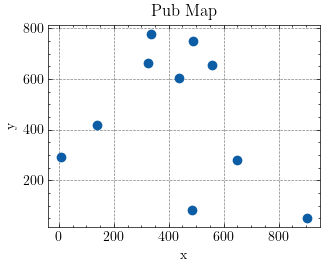

In [4]:
showPubMap(Pubs)

In [5]:
currentTime = 10

# show waiting times for all pubs
for p in Pubs:
    print('Pub ID: ', p.pubID, ' Waiting Time: ', p.getWaitingTime(currentTime))

Pub ID:  0  Waiting Time:  590
Pub ID:  1  Waiting Time:  490
Pub ID:  2  Waiting Time:  481
Pub ID:  3  Waiting Time:  165
Pub ID:  4  Waiting Time:  195
Pub ID:  5  Waiting Time:  360
Pub ID:  6  Waiting Time:  360
Pub ID:  7  Waiting Time:  551
Pub ID:  8  Waiting Time:  118
Pub ID:  9  Waiting Time:  97


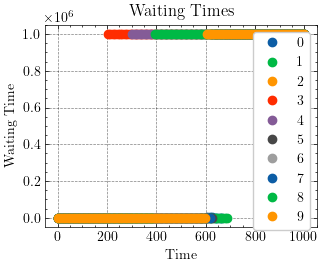

In [6]:
currT = np.linspace(0, 1000, 100)

# evaluate the waiting time for all pubs at different times
for p in Pubs:
    waitingTimes = []
    for t in currT:
        waitingTimes.append(p.getWaitingTime(t))
    plt.plot(currT, waitingTimes, 'o', label=p.pubID)
    plt.xlabel('Time')
    plt.ylabel('Waiting Time')
    plt.title('Waiting Times')
    plt.legend()

# plot wainting times for all pubs in a subplot


# create a figure with subplots



# Implementation of the Ant-Colony Optimization

1.) Init the pheromone and visibility matrix


In [7]:
# Use the random pubs
Pubs = PCF.initPubs('RandomPubs.csv')


In [8]:
# simulation paramters
tau0 = 1
alpha = 1
beta = 1
gamma = 1 
rho = 0.2

# simulation counters
time = 0
timeMax = int(60*12)            # 12 hours in minutes - 3pm to 3am 
iter = 0
# population size of ants
popSize = 100

# velocity of an ant
velAnt = 1


In [9]:
# init the pheromone matrix which is a 2D array with the size of the number of pubs
pheromoneMatrix = np.ones((len(Pubs), len(Pubs)))
pheromoneMatrix = pheromoneMatrix * tau0


# the visibility matrix is in this case not only the distance between the pubs, but also takes into consideration
# the waiting time at the next pub
# we inititalize the matrix at time = 0

# init the distance matrix D
distanceMatrix = np.zeros((len(Pubs), len(Pubs)))
for i in range(len(Pubs)):
    for j in range(i, len(Pubs)):
        distanceMatrix[i][j] = PCF.getDistance(Pubs[i], Pubs[j])
        #  print("i and j: ", i, j, " distance: ", distanceMatrix[i][j])

        distanceMatrix[j][i] = distanceMatrix[i][j]

# set the diagonal to 10e15
for i in range(len(Pubs)):
    distanceMatrix[i][i] = 10e15

# init the visibility matrix
visibilityMatrix = 1 / distanceMatrix

## Test the ACO without time dependecy, for this set timeMatrix = ones and gamma = 1

In [10]:
# Use the random pubs
Pubs = PCF.initPubs('RandomPubs.csv')

# determine the waiting time vector
time = 180
waitingTimeVector = np.zeros(len(Pubs))
for i, p in enumerate(Pubs):
    waitingTimeVector[i] = p.getWaitingTime(time)

print("Waiting Time Vector: ", waitingTimeVector)
# print opening hours
for p in Pubs:
    print("Pub ID: ", p.pubID, " Opening Time: ", p.openingTime, " Closing Time: ", p.closingTime, " Waiting Time: ", p.getWaitingTime(time), " Popularity: ", p.popularity, " get Queue Length: ", p.getQueueLength(time), " Peaktime: ", p.peakTime)

Waiting Time Vector:  [420. 320. 311. 699.  90. 190. 190. 381. 300.   0.]
Pub ID:  0  Opening Time:  600  Closing Time:  673  Waiting Time:  420  Popularity:  17  get Queue Length:  0  Peaktime:  618
Pub ID:  1  Opening Time:  500  Closing Time:  692  Waiting Time:  320  Popularity:  5  get Queue Length:  0  Peaktime:  570
Pub ID:  2  Opening Time:  491  Closing Time:  613  Waiting Time:  311  Popularity:  7  get Queue Length:  0  Peaktime:  543
Pub ID:  3  Opening Time:  175  Closing Time:  200  Waiting Time:  699  Popularity:  7  get Queue Length:  699  Peaktime:  178
Pub ID:  4  Opening Time:  205  Closing Time:  297  Waiting Time:  90  Popularity:  1  get Queue Length:  65  Peaktime:  217
Pub ID:  5  Opening Time:  370  Closing Time:  631  Waiting Time:  190  Popularity:  8  get Queue Length:  0  Peaktime:  522
Pub ID:  6  Opening Time:  370  Closing Time:  572  Waiting Time:  190  Popularity:  15  get Queue Length:  0  Peaktime:  493
Pub ID:  7  Opening Time:  561  Closing Time:  

49.0


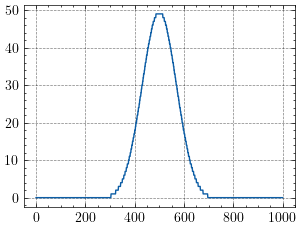

In [11]:
def getQueueLength(currentTime):
    # gaussian distribution with the mean = peakTime
    sigma = 70
    peaktime = 500
    mu = peaktime
    popul = 50
    term1 = popul 
    # *  1 / (sigma * np.sqrt(2 * np.pi))
    term2 = np.exp(-0.5 * ((currentTime - mu)/sigma)**2)
    queueLength = term1 * term2
    # print("Term1: ", term1)
    # print("Term2: ", term2)
    # print("Queue Length: ", queueLength)
    return int(queueLength)

# plot from t = 0 to t = 1000
t = np.linspace(0, 1000, 1000)
queueLength = np.zeros(len(t))
for i, time in enumerate(t):
    queueLength[i] = getQueueLength(time)

plt.plot(t, queueLength)
print(max(queueLength))
